## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [19]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import models_mae
import models_vit
import librosa
import librosa.display

In [20]:
def print_state_dict(dicts):
    for name, param in dicts.items():
        print(f"Name: {name}, Shape: {param.size()}")

In [11]:
model = getattr(models_mae, 'mae_vit_base_patch16')(in_chans=1, audio_exp=True,img_size=(256,128))

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print('Number of parameters:', nb_params)
print_state_dict(model.state_dict())

Number of parameters: 111164928
Name: cls_token, Shape: torch.Size([1, 1, 768])
Name: pos_embed, Shape: torch.Size([1, 129, 768])
Name: mask_token, Shape: torch.Size([1, 1, 512])
Name: decoder_pos_embed, Shape: torch.Size([1, 129, 512])
Name: patch_embed.proj.weight, Shape: torch.Size([768, 1, 16, 16])
Name: patch_embed.proj.bias, Shape: torch.Size([768])
Name: blocks.0.norm1.weight, Shape: torch.Size([768])
Name: blocks.0.norm1.bias, Shape: torch.Size([768])
Name: blocks.0.attn.qkv.weight, Shape: torch.Size([2304, 768])
Name: blocks.0.attn.qkv.bias, Shape: torch.Size([2304])
Name: blocks.0.attn.proj.weight, Shape: torch.Size([768, 768])
Name: blocks.0.attn.proj.bias, Shape: torch.Size([768])
Name: blocks.0.norm2.weight, Shape: torch.Size([768])
Name: blocks.0.norm2.bias, Shape: torch.Size([768])
Name: blocks.0.mlp.fc1.weight, Shape: torch.Size([3072, 768])
Name: blocks.0.mlp.fc1.bias, Shape: torch.Size([3072])
Name: blocks.0.mlp.fc2.weight, Shape: torch.Size([768, 3072])
Name: blocks.

In [3]:
model = getattr(models_vit, 'vit_base_patch16')(in_chans=1, img_size=(256,128))

nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print('Number of parameters:', nb_params)

Number of parameters: 86120680


In [12]:
checkpoint = torch.load('/home/ubuntu/workspace/project/AudioMAE/ckpt/pretrained.pth', map_location='cpu')
print_state_dict(checkpoint['model'])

Name: cls_token, Shape: torch.Size([1, 1, 768])
Name: pos_embed, Shape: torch.Size([1, 513, 768])
Name: mask_token, Shape: torch.Size([1, 1, 512])
Name: decoder_pos_embed, Shape: torch.Size([1, 513, 512])
Name: patch_embed.proj.weight, Shape: torch.Size([768, 1, 16, 16])
Name: patch_embed.proj.bias, Shape: torch.Size([768])
Name: blocks.0.norm1.weight, Shape: torch.Size([768])
Name: blocks.0.norm1.bias, Shape: torch.Size([768])
Name: blocks.0.attn.qkv.weight, Shape: torch.Size([2304, 768])
Name: blocks.0.attn.qkv.bias, Shape: torch.Size([2304])
Name: blocks.0.attn.proj.weight, Shape: torch.Size([768, 768])
Name: blocks.0.attn.proj.bias, Shape: torch.Size([768])
Name: blocks.0.norm2.weight, Shape: torch.Size([768])
Name: blocks.0.norm2.bias, Shape: torch.Size([768])
Name: blocks.0.mlp.fc1.weight, Shape: torch.Size([3072, 768])
Name: blocks.0.mlp.fc1.bias, Shape: torch.Size([3072])
Name: blocks.0.mlp.fc2.weight, Shape: torch.Size([768, 3072])
Name: blocks.0.mlp.fc2.bias, Shape: torch.Siz

In [13]:
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['pos_embed', 'decoder_pos_embed']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

Removing key pos_embed from pretrained checkpoint
Removing key decoder_pos_embed from pretrained checkpoint


In [15]:
print_state_dict(checkpoint['model'])

Name: cls_token, Shape: torch.Size([1, 1, 768])
Name: mask_token, Shape: torch.Size([1, 1, 512])
Name: patch_embed.proj.weight, Shape: torch.Size([768, 1, 16, 16])
Name: patch_embed.proj.bias, Shape: torch.Size([768])
Name: blocks.0.norm1.weight, Shape: torch.Size([768])
Name: blocks.0.norm1.bias, Shape: torch.Size([768])
Name: blocks.0.attn.qkv.weight, Shape: torch.Size([2304, 768])
Name: blocks.0.attn.qkv.bias, Shape: torch.Size([2304])
Name: blocks.0.attn.proj.weight, Shape: torch.Size([768, 768])
Name: blocks.0.attn.proj.bias, Shape: torch.Size([768])
Name: blocks.0.norm2.weight, Shape: torch.Size([768])
Name: blocks.0.norm2.bias, Shape: torch.Size([768])
Name: blocks.0.mlp.fc1.weight, Shape: torch.Size([3072, 768])
Name: blocks.0.mlp.fc1.bias, Shape: torch.Size([3072])
Name: blocks.0.mlp.fc2.weight, Shape: torch.Size([768, 3072])
Name: blocks.0.mlp.fc2.bias, Shape: torch.Size([768])
Name: blocks.1.norm1.weight, Shape: torch.Size([768])
Name: blocks.1.norm1.bias, Shape: torch.Size(

### Define utils

In [21]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(256,128), decoder_depth=8, decoder_mode=1)
#     model = getattr(models_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128), decoder_depth=8, decoder_mode=1)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()
    for k in ['pos_embed', 'decoder_pos_embed']:
        if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]

    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


In [22]:
MELBINS=128
TARGET_LEN=256
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    # ESC: 512 (8K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

In [23]:
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

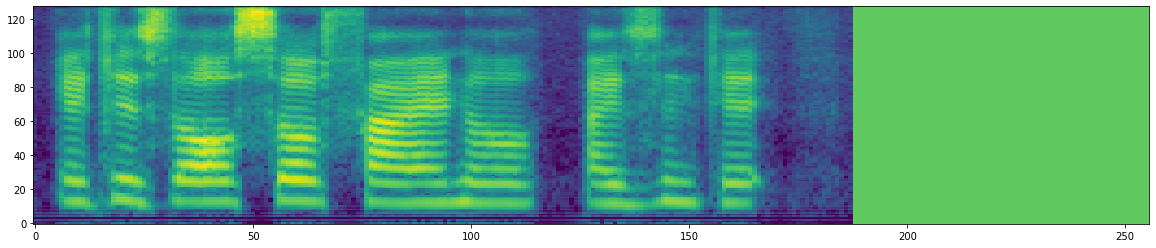

In [36]:
wav_file = '/home/ubuntu/workspace/project/AudioMAE/ckpt/LA_T_8801256.flac'
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

In [71]:
#y, sr = librosa.load(wav_file)
#M = librosa.feature.melspectrogram(y=y, sr=sr)
#M_db = librosa.power_to_db(M, ref=np.max)
#plt.figure()
#librosa.display.specshow(M_db, y_axis='mel', x_axis='time')
#plt.colorbar()

In [25]:
#chkpt_dir = '/checkpoint/berniehuang/experiments/53417041/checkpoint-80.pth'
chkpt_dir = '/home/ubuntu/workspace/project/AudioMAE/ckpt/pretrained.pth'
model = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')
nb_params = sum([param.view(-1).size()[0] for param in model.parameters()])
print('Number of parameters:', nb_params)

Removing key pos_embed from pretrained checkpoint
Removing key decoder_pos_embed from pretrained checkpoint
_IncompatibleKeys(missing_keys=['pos_embed', 'decoder_pos_embed'], unexpected_keys=[])
Model loaded.
Number of parameters: 136501248


In [26]:
x = torch.tensor(fbank)
print(x.shape)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = x.unsqueeze(dim=0)
print(x.shape)
#x = torch.einsum('nhwc->nchw', x)

torch.Size([256, 128])
torch.Size([1, 1, 256, 128])


/tmp/ipykernel_41928/2277072120.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


y_shape: torch.Size([1, 128, 256]) torch.Size([1, 128])
torch.Size([256, 128])


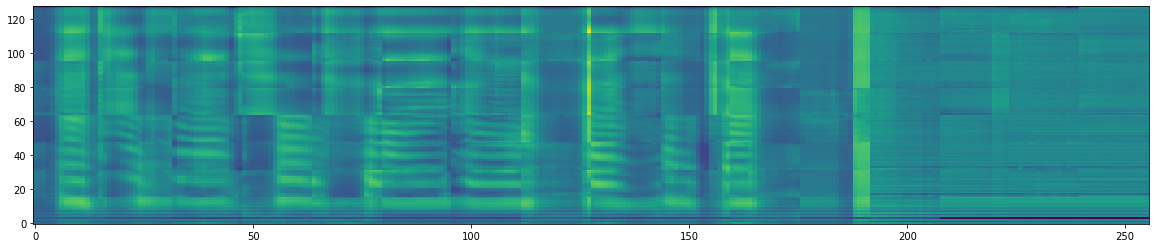

In [27]:
# run MAE
loss, y, mask,_ = model(x.float(), mask_ratio=0.5)
print('y_shape:',y.shape, mask.shape)
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

y_fbank = y.squeeze(dim=0)
y_fbank = y_fbank.squeeze(dim=-1)
print(y_fbank.shape)
display_fbank(y_fbank)


In [28]:
# visualize the mask
mask = mask.detach()
#mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
print(mask.shape)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', x)

# masked image
im_masked = x * (1 - mask) 

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask



#x[0]
#im_masked[0]
#y[0]
#im_paste[0], "reconstruction + visible")


torch.Size([1, 128, 256])


In [29]:
minmin = np.min([x[0].min(), im_masked[0].min(), y[0].min(), im_paste[0].min()])
maxmax = np.max([x[0].max(), im_masked[0].max(), y[0].max(), im_paste[0].max()])
minmin *= 10
maxmax *= 1
minmin=-10
maxmax=10
start=0
end=200
print(minmin,maxmax)

-10 10


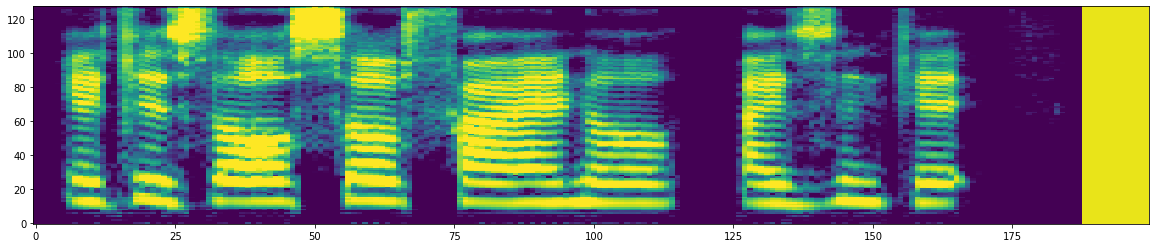

In [30]:
display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)

In [31]:
im_masked2 = im_masked + (mask)*-10

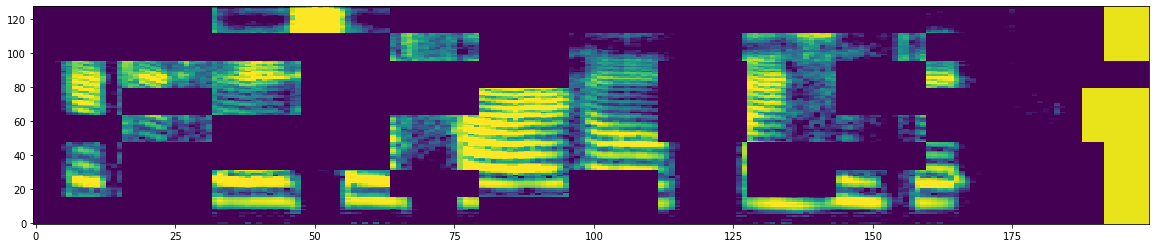

In [32]:
display_fbank(im_masked2[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

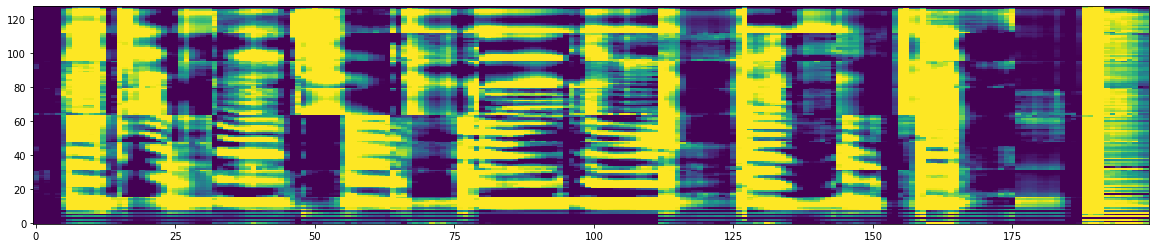

In [33]:
display_fbank((y[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)

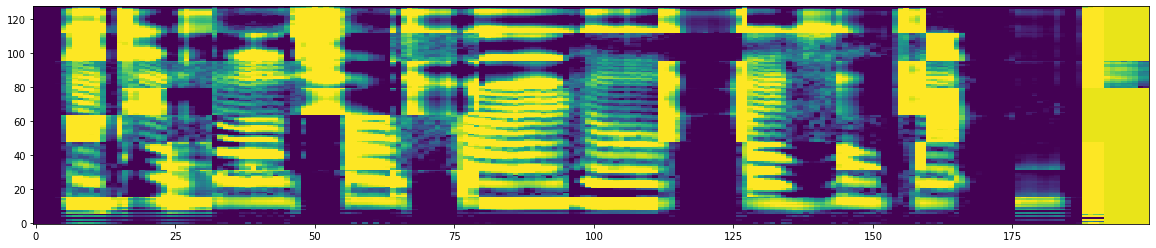

In [34]:
display_fbank(im_paste[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

In [60]:
# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

In [25]:
#display_fbank((y * mask - 999).squeeze())